In [63]:

from nba_api.stats.endpoints import playercareerstats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nba_api.stats.static import players
from sklearn.linear_model import LinearRegression

# get_players returns a list of dictionaries, each representing a player.
nba_players = players.get_players()

# Show all columns
pd.options.display.max_columns = None

In [64]:
def cleanCarData(name):
    """
    This function cleans the data for a given player and removes any duplicate rows from the dataframe
    based on the SEASON_ID column. It also includes the total row for each season and sorts the data by SEASON_ID.
    """
    # get player data
    player = getPlayerID(name)
    player = plotPlayerStats(player)

    # drop any duplicate rows
    player_drop = player.drop_duplicates()

    # get the 'TOT' rows for each season
    player_tot = player_drop[player_drop['TEAM_ABBREVIATION'] == 'TOT']

    # remove any duplicate SEASON_ID rows that are not 'TOT'
    player_dup = player_drop.duplicated(subset=['SEASON_ID'], keep=False)
    out = player[~player_dup]

    # combine the 'TOT' rows with the cleaned dataframe and sort by SEASON_ID
    out_tot = pd.concat([out, player_tot])
    return out_tot.sort_values(by=['SEASON_ID'])


def plotPlayerStats(id):
    """Returns a dataframe containing the player's career statistics."""
    career = playercareerstats.PlayerCareerStats(player_id=id)
    return career.get_data_frames()[0]


def getPlayerID(Name):
    """Returns the player ID for a given player name."""
    nba_players = players.get_players()
    ID = [player for player in nba_players
          if player['full_name'] == Name][0]
    return ID['id']

def getPlayerName(ID):
    """Returns the player ID for a given player name."""
    nba_players = players.get_players()
    Name = [player for player in nba_players
          if player['id'] == ID][0]
    return Name['full_name']


def plotPts(player):
    """Plots the player's points per game over time."""
    plot_stats(plotPlayerStats(getPlayerID(player)),['PTS'])
    
def plotCarStats(player):
    """Plots the player's career statistics over time."""
    plotPlayerStats(getPlayerID(player))

def plot_stats(df, stat_list):
    """
    Plots multiple stats over time for a given DataFrame.
    The stat_list parameter should be a list of column names to plot.
    """
    # create a new DataFrame with only the specified columns
    stat_df = df[stat_list + ['SEASON_ID']]

    # set the index to the season ID column
    stat_df.set_index('SEASON_ID', inplace=True)

    # plot each stat on a separate axis
    fig, ax = plt.subplots(figsize=(20, 10))
    for i, stat in enumerate(stat_list):
        # plot the stat on the current axis
        ax.plot(stat_df.index, stat_df[stat], label=stat, color=plt.cm.get_cmap('Set1')(i/len(stat_list)))
        ax.tick_params(axis='y', labelcolor=plt.cm.get_cmap('Set1')(i/len(stat_list)))
        
    # set axis labels and title
    ax.set_xlabel('Season', fontsize=20)
    ax.set_ylabel('Stats', fontsize=20)
    ax.set_title('Stats over time', fontsize=24)
    
    # set the y axis limits and ticks
    ax.set_ylim([0, df[stat_list].max().max()])
    y_ticks = np.arange(0, df[stat_list].max().max(), df[stat_list].max().max() / 5)
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', labelsize=16)
    
    # create a legend for the plot
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper left', fontsize=16)

    # adjust the layout of the plot
    plt.subplots_adjust(left=0.15, bottom=0.15)

    # rotate x-axis labels
    plt.xticks(rotation=90)

    # show the plot
    plt.show()

    
def plotPAR(player):
    """Plot a player's career PTS AST and REB."""
    plot_stats(player,['PTS','AST','REB'])
    
def graphCumStats(player):
    """Given a player DF, create cumlative columns and graph them"""
    player['TOT_PTS'] = player['PTS'].cumsum()
    player['TOT_AST'] = player['AST'].cumsum()
    player['TOT_REB'] = player['REB'].cumsum()
    
    # plot graph
    plot_stats(player,['TOT_PTS','TOT_AST','TOT_REB'])
    
def graphCareer(name):
    """Plot season stats, cum stats, and career chart"""
    plotPAR(cleanCarData(name))
    display(cleanCarData(name))
    graphCumStats(cleanCarData(name))
    

def plot_players(players, stats):
    """
    Plots the specified stats for each player in the given list of dataframes.
    The stats for each player are indicated by a different line style.
    """
    fig, ax = plt.subplots(figsize=(20, 10))

    # Loop through the players and plot the specified stats
    for i, player in enumerate(players):
        
        # Add player SZN no column data
        player['SZN'] = list(range(1,len(player)+1))
        
        # Create a new dataframe with only the specified stats
        stat_df = player[stats + ['SZN']]

        # Set the index to the season no column
        stat_df.set_index('SZN', inplace=True)

        # Plot each stat on a separate axis
        for j, stat in enumerate(stats):
            # Get player ID and name
            playerName = getPlayerName(player['PLAYER_ID'][0]) + " " + stat
            
            # Set the line style for this stat
            linestyle = ['-', '--', ':', '-.'][j % 4]

            # Plot the stat on the current axis
            ax.plot(stat_df.index, stat_df[stat], 
                    color=plt.cm.get_cmap('Set1')(i / len(players)), label= playerName, 
                    linestyle=linestyle, linewidth=2.5)
            ax.tick_params(axis='y', labelcolor=plt.cm.get_cmap('Set1')(i / len(players)))

    # Set axis labels and title
    ax.set_xlabel('Season', fontsize=20)
    ax.set_ylabel('Stats', fontsize=20)
    ax.set_title('Stats over time', fontsize=24)

    # Set the y axis limits and ticks
    ax.set_ylim([0, max(player[stats].max().max() for player in players)])
    y_ticks = np.arange(0, max(player[stats].max().max() for player in players), 
                         max(player[stats].max().max() for player in players) / 5)
    ax.set_yticks(y_ticks)
    ax.tick_params(axis='both', labelsize=16)

    # Create a legend for the plot
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='upper left', fontsize=16)

    # Adjust the layout of the plot
    plt.subplots_adjust(left=0.15, bottom=0.15)

    # Rotate x-axis labels
    plt.xticks(rotation=90)

    # Show the plot
    plt.show()



def plot_stat_with_trendline(player, stat):
    """
    Plots the specified stat for the given player and adds a trendline to the plot.
    Displays the trendline equation next to the trendline key.
    """
    # Create a copy of the player dataframe with only the specified stat
    player_stat = player[[stat]].copy()

    # Add a column for the season number
    player_stat['SZN'] = range(1, len(player_stat) + 1)

    # Fit a linear regression to the data
    reg = LinearRegression().fit(player_stat[['SZN']], player_stat[stat])

    # Plot the data points and the trendline
    fig, ax = plt.subplots()
    ax.plot(player_stat['SZN'], player_stat[stat], 'o', label=stat)
    ax.plot(player_stat['SZN'], reg.predict(player_stat[['SZN']]), '--', label='Trendline')

    # Add the trendline equation to the plot
    equation = f'y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}'
    plt.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=12, va='top')

    # Set the axis labels and title
    ax.set_xlabel('Season')
    ax.set_ylabel(stat)
    ax.set_title(f'{player["PLAYER_NAME"].iloc[0]} {stat} with Trendline')

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()

#Trendline equation
def trendline_equation(player, stat):
    """
    Takes a player dataframe and a stat and returns the trendline equation in English terms.
    """
    
    # Add a column for the season number
    player['SZN'] = range(1, len(player) + 1)
    
    # Create a new dataframe with only the specified stat and season columns
    df = player[[stat, 'SZN']]

    # Create a LinearRegression object
    lr = LinearRegression()

    # Fit the regression line to the data
    lr.fit(df[['SZN']], df[stat])

    # Get the slope and y-intercept of the regression line
    slope = lr.coef_[0]
    y_intercept = lr.intercept_

    # Generate the trendline equation in English terms
    if slope > 0:
        equation = f"{getPlayerName(player['PLAYER_ID'][0])}'s {stat.lower()} increased by {slope:.2f} points per season on average over their career."
    elif slope < 0:
        equation = f"{getPlayerName(player['PLAYER_ID'][0])}'s {stat.lower()} decreased by {-slope:.2f} points per season on average over their career."
    else:
        equation = f"{getPlayerName(player['PLAYER_ID'][0])}'s {stat.lower()} did not change over their career."

    return equation
    
    
#Function that pulls team of player
def getTeam(id):
    """Given a player ID, return the team they played for"""
    player = playercareerstats.PlayerCareerStats(player_id=id)
    player_df = player.get_data_frames()[0]
    return player_df['TEAM_ABBREVIATION']


In [65]:
"""
graphCareer(name)
graphCumStats(player)
plotPAR(player)
cleanCarData(player)
plotPlayerStats(id)
getPlayerID(Name)
plotPts(player)    
plotCarStats(player)
plot_stats(df, stat_list)
"""

'\ngraphCareer(name)\ngraphCumStats(player)\nplotPAR(player)\ncleanCarData(player)\nplotPlayerStats(id)\ngetPlayerID(Name)\nplotPts(player)    \nplotCarStats(player)\nplot_stats(df, stat_list)\n'

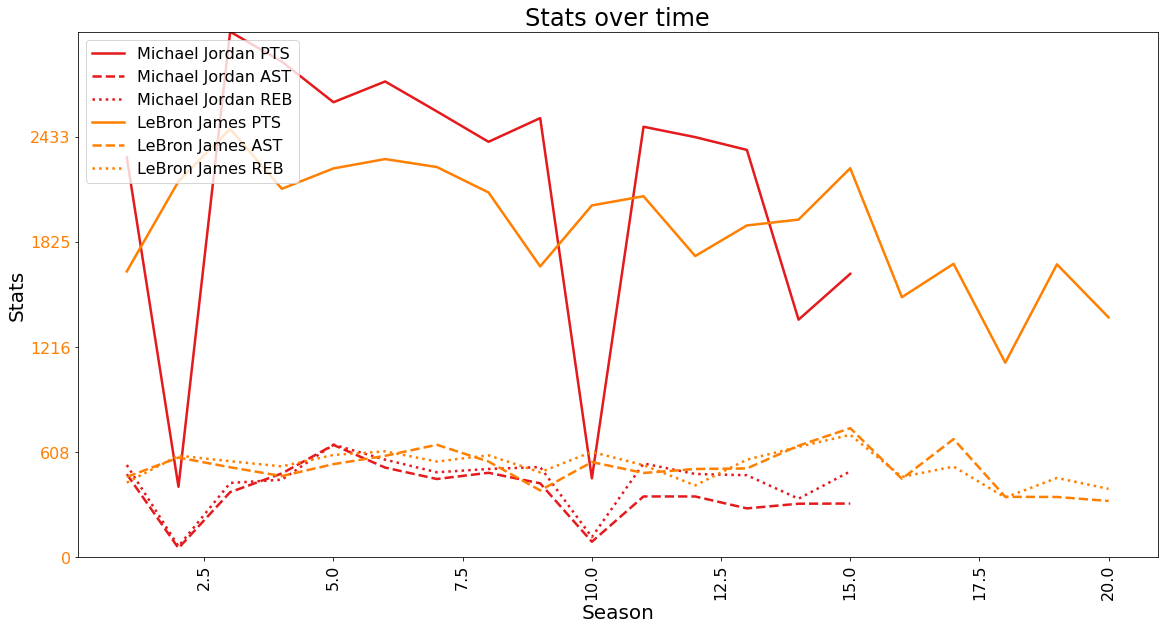

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,SZN
0,893,1984-85,00,1610612741,CHI,22.0,82,82,3144.0,837,1625,0.515,9,52,0.173,630,746,0.845,167,367,534,481,196,69,291,285,2313,1
1,893,1985-86,00,1610612741,CHI,23.0,18,7,451.0,150,328,0.457,3,18,0.167,105,125,0.840,23,41,64,53,37,21,45,46,408,2
2,893,1986-87,00,1610612741,CHI,24.0,82,82,3281.0,1098,2279,0.482,12,66,0.182,833,972,0.857,166,264,430,377,236,125,272,237,3041,3
3,893,1987-88,00,1610612741,CHI,25.0,82,82,3311.0,1069,1998,0.535,7,53,0.132,723,860,0.841,139,310,449,485,259,131,252,270,2868,4
4,893,1988-89,00,1610612741,CHI,26.0,81,81,3255.0,966,1795,0.538,27,98,0.276,674,793,0.850,149,503,652,650,234,65,290,247,2633,5
5,893,1989-90,00,1610612741,CHI,27.0,82,82,3197.0,1034,1964,0.526,92,245,0.376,593,699,0.848,143,422,565,519,227,54,247,241,2753,6
6,893,1990-91,00,1610612741,CHI,28.0,82,82,3034.0,990,1837,0.539,29,93,0.312,571,671,0.851,118,374,492,453,223,83,202,229,2580,7
7,893,1991-92,00,1610612741,CHI,29.0,80,80,3102.0,943,1818,0.519,27,100,0.270,491,590,0.832,91,420,511,489,182,75,200,201,2404,8
8,893,1992-93,00,1610612741,CHI,30.0,78,78,3067.0,992,2003,0.495,81,230,0.352,476,569,0.837,135,387,522,428,221,61,207,188,2541,9
9,893,1994-95,00,1610612741,CHI,32.0,17,17,668.0,166,404,0.411,16,32,0.500,109,136,0.801,25,92,117,90,30,13,35,47,457,10


In [66]:
#graphCareer('Mason Plumlee')
mj = plotPlayerStats(getPlayerID("Michael Jordan"))

lj = plotPlayerStats(getPlayerID("LeBron James"))


gi = plotPlayerStats(getPlayerID("Giannis Antetokounmpo"))

mj['SZN'] = list(range(1,len(mj)+1))
lj['SZN'] = list(range(1,len(lj)+1))


plot_players([mj,lj],['PTS','AST','REB'])
mj

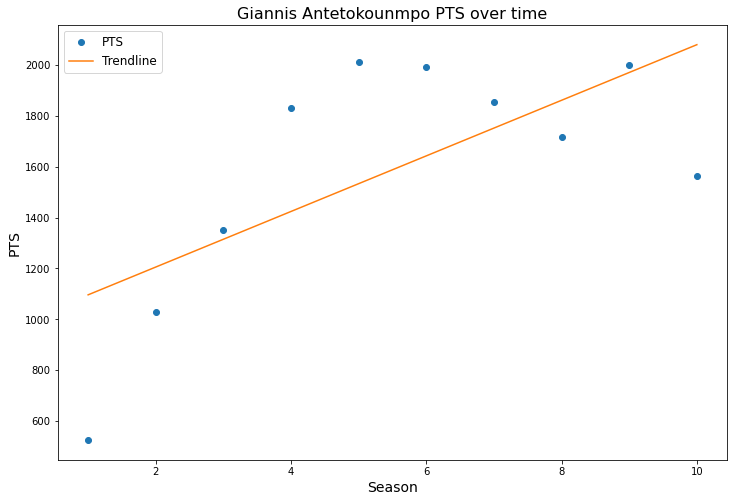

In [67]:
gi
plot_stat_trendline(gi,'PTS')

In [69]:
trendline_equation(gi,'PTS')
trendline_equation(mj,'PTS')
trendline_equation(lj,'PTS')

"LeBron James's pts decreased by 38.09 points per season on average over their career."

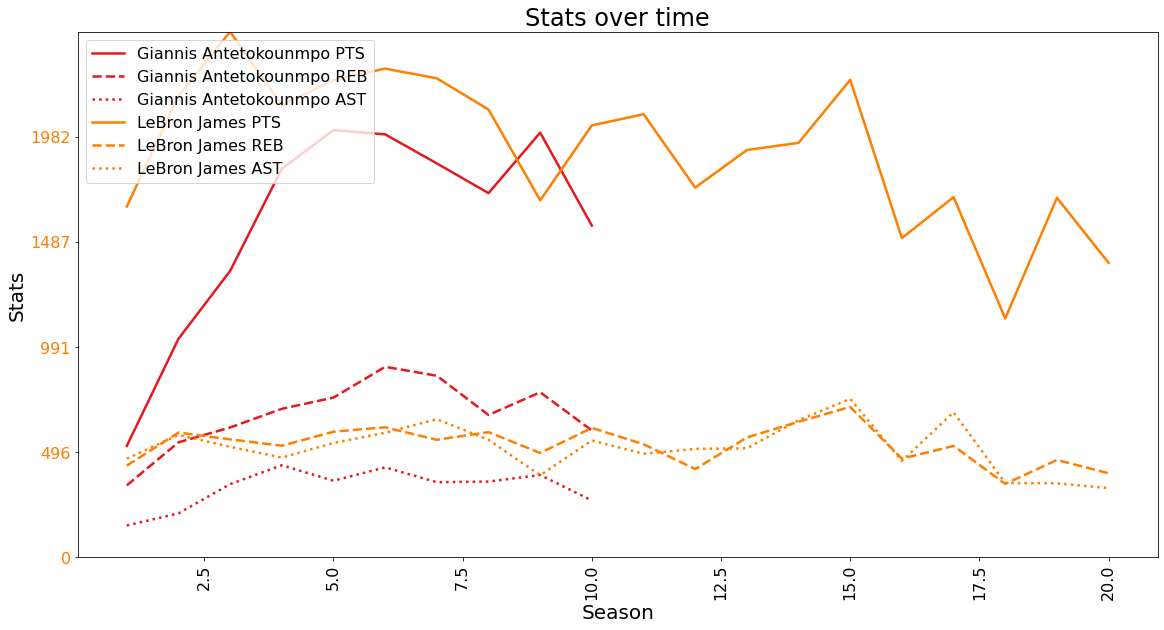

In [72]:
plot_players([gi,lj],['PTS','REB','AST'])